## 深度卷积神经网络（AlexNet）

2012年，当Alex Krizhevsky和llya Sutskever实现了可以在GPU硬件上运行的深度卷积神经网络时，一个重大突破出现了。他们意识到卷积神经网络中的计算瓶颈：卷积和矩阵乘法，都是可以在硬件上并行化的操作。于是，他们使用两个显存为3GB的NVIDIA GTX580 GPU实现了快速卷积运算。他们的创新cuda-convnet几年来一直是行业标准，并推动了深度学习热潮。

AlexNet使用了8层卷积神经网络，和LeNet的架构非常相似。AlexNet以很大的优势赢得了2012年ImageNet图像识别挑战赛。

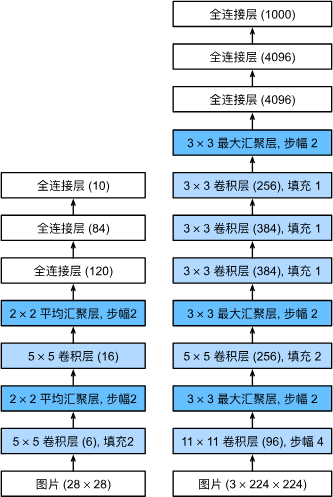

AlexNet和LeNet的设计理念非常相似，但也存在显著差异。

1. AlexNet比相对较小的LeNet5要深得多。AlexNet由八层组成：五个卷积层、两个全连接隐藏层和一个全连接输出层。

2. AlexNet使用ReLU而不是sigmoid作为其激活函数。


### 模型设计

在AlexNet的第一层，卷积窗口的形状是$11\times11$。
由于ImageNet中大多数图像的宽和高比MNIST图像的多10倍以上，因此，需要一个更大的卷积窗口来捕获目标。
第二层中的卷积窗口形状被缩减为$5\times5$，然后是$3\times3$。
此外，在第一层、第二层和第五层卷积层之后，加入窗口形状为$3\times3$、步幅为2的最大汇聚层。
而且，AlexNet的卷积通道数目是LeNet的10倍。

在最后一个卷积层后有两个全连接层，分别有4096个输出。
这两个巨大的全连接层拥有将近1GB的模型参数。
由于早期GPU显存有限，原版的AlexNet采用了双数据流设计，使得每个GPU只负责存储和计算模型的一半参数。
幸运的是，现在GPU显存相对充裕，所以现在很少需要跨GPU分解模型（因此，书中（动手学深度学习）的AlexNet模型在这方面与原始论文稍有不同）。

### 容量控制和预处理

AlexNet通过暂退法控制全连接层的模型复杂度，而LeNet只使用了权重衰减。

为了进一步扩充数据，AlexNet在训练时增加了大量的图像增强数据，如翻转、裁切和变色。
这使得模型更健壮，更大的样本量有效地减少了过拟合。

In [16]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    # 这里使用一个11*11的更大窗口来捕捉对象
    # 同时，步幅为4，以减少输出的高度和宽度
    # 另外，输出通道的数目远大于LeNet
    nn.Conv2d(1, 96, kernel_size = 11, stride = 4, padding = 1), nn.ReLU(),
    nn.MaxPool2d(kernel_size = 3, stride = 2),
    # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
    nn.Conv2d(96, 256, kernel_size = 5, padding = 2), nn.ReLU(),
    nn.MaxPool2d(kernel_size = 3, stride = 2), 
    # 使用三个连续的卷积层和较小的卷积窗口
    # 除了最后的卷积层，输出通道的数量进一步增加
    # 在前两个卷积层之后，汇聚层不用于减少输入的高度和宽度
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout来减轻过拟合
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    # 最后是输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
    nn.Linear(4096, 10))

构造一个高度和宽度都为224的单通道数据，来观察每一层输出的形状。

In [17]:
X = torch.randn(1, 1, 224, 224)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

### 读取数据集

在这里使用Fashion-MNIST数据集进行训练。因为即使在现代GPU上，训练ImageNet模型，同时使其收敛可能需要数小时或数天的时间。将AlexNet直接应用于Fashion-MNIST的一个问题是，Fashion-MNIST图像的分辨率（$28×28$）低于ImageNet图像。为了解决这个问题，我们将它增加到$224×224$（通常来讲这不是一个明智的做法，但在这里这样做是为了有效使用AlexNet架构）。这里需要使用d2l.load_data_fashion_mnist函数中的resize参数执行此调整。

In [18]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize = 224)

### 训练AlexNet

与LeNet相比，这里的主要变化是使用更小的学习速率训练，这是因为网络更深更广、图像分辨率更高，训练卷积神经网络就更昂贵。


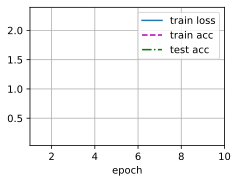

In [ ]:
lr, num_epochs = 0.01, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())